# Discrete Wavelet Transform 

> Sandbox

In [558]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [559]:
from pathlib import Path
from tqdm import tqdm
import re

import fastcore.all as fc
import pandas as pd

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

import pywt

In [560]:
from lssm.loading import load_ossl, load_mir_kex_spike, load_nir_kex_spike
from lssm.visualization import plot_spectra
from sklearn.pipeline import Pipeline
from lssm.preprocessing import SpikeMean

In [564]:
scan_type = 'MIR'

if scan_type == 'MIR':
    src_dir = Path().home() / 'pro/data/k-spiking/mir'
    X, wavenumbers, names = load_mir_kex_spike(src_dir)
else:
    fname = Path().home() / 'pro/data/k-spiking/nir/2023-12-8 _FT-NIR-K-spiked soil.xlsx'
    X, wavenumbers, names = load_nir_kex_spike(fname)

In [565]:
X_mean, names_mean = SpikeMean(names).fit_transform(X)

print(f'X shape: {X_mean.shape}')
print(f'Sample names: {names_mean}')

NameError: name 'names' is not defined

In [ ]:
mask_smp = np.char.find(names, 'TM') == 0

In [501]:
names[mask_smp]

array(['TM4.1-0-0', 'TM4.1-0-1', 'TM4.1-0-2', 'TM4.1-0-3', 'TM4.1-0-4',
       'TM4.1-0-5', 'TM4.1-1-0', 'TM4.1-1-1', 'TM4.1-1-2', 'TM4.1-1-3',
       'TM4.1-2-0', 'TM4.1-2-1', 'TM4.1-2-2', 'TM4.1-2-3', 'TM4.1-3-0',
       'TM4.1-3-1', 'TM4.1-3-2', 'TM4.1-3-3', 'TM4.1-3-4'], dtype='<U9')

In [502]:
# smp_type, K,    w1,    w2,    w3,     w4, 
# SPA,      0.3,  7056

In [503]:
# wn,   coeff,  level,  K,      smp_name
# 4002, 0.2,    5,      0.3,    SPA-0
# 3250, 0.82,   6,      0.3,    SPA-0

In [516]:
wavelet_name = 'db1'

signal_length = X.shape[-1]
sample_signal = X[mask_smp, :][1]
print(signal_length)

max_level = pywt.dwt_max_level(data_len=signal_length, filter_len=pywt.Wavelet(wavelet_name).dec_len)
coeffs = pywt.wavedec(sample_signal, wavelet_name, level=max_level)

1738


In [517]:
for i, level in enumerate(coeffs):
    print(f'level: {i} | # coeffs: {len(level)} | max: {np.max(level):.3f} | argmax: {np.argmax(level)} | argmin: {np.argmin(level)}')     

level: 0 | # coeffs: 2 | max: 19.994 | argmax: 0 | argmin: 1
level: 1 | # coeffs: 2 | max: 0.904 | argmax: 0 | argmin: 1
level: 2 | # coeffs: 4 | max: 0.687 | argmax: 1 | argmin: 2
level: 3 | # coeffs: 7 | max: 0.399 | argmax: 6 | argmin: 4
level: 4 | # coeffs: 14 | max: 0.503 | argmax: 12 | argmin: 2
level: 5 | # coeffs: 28 | max: 0.222 | argmax: 24 | argmin: 5
level: 6 | # coeffs: 55 | max: 0.136 | argmax: 49 | argmin: 19
level: 7 | # coeffs: 109 | max: 0.066 | argmax: 99 | argmin: 19
level: 8 | # coeffs: 218 | max: 0.033 | argmax: 198 | argmin: 39
level: 9 | # coeffs: 435 | max: 0.012 | argmax: 396 | argmin: 156
level: 10 | # coeffs: 869 | max: 0.004 | argmax: 792 | argmin: 312


In [522]:
round(1738 / 218 / 2) * 2

8

In [523]:
198 * (8+4)

2376

In [527]:
def indices_of_percentile(arr, percentile):
    threshold = np.percentile(arr, percentile)  
    top_indices = np.where(arr >= threshold)[0]
    return top_indices[np.argsort(arr[top_indices])[::-1]]

In [528]:
indices_of_percentile(coeffs[-1], 98)

array([792, 793, 794, 791, 795, 796, 783, 360, 797, 361, 272, 359, 327,
       784, 326, 268, 362, 353])

In [508]:
get_wn(10, signal_length, 476)

727.032

In [532]:
len(coeffs[-1])

869

In [ ]:
869, 870, 871

In [ ]:
# 1       0  
# 1 1 1 1 0 0 0 0
* 4 + 4/2

In [535]:
upsampling_factor = round((signal_lenxgth/len(coeffs[-2])) / 2) * 2; upsampling_factor

4

In [ ]:
upsampling_factor*(idx + 1/2)

In [539]:
4*(235 + 1/2)

940

In [542]:
def get_wn(idx, signal_length, n_coeffs): 
    upsampling_factor = round((signal_length/n_coeffs) / 2) * 2
    # return wavenumbers[idx * upsampling_factor + upsampling_factor/2]
    return wavenumbers[idx * upsampling_factor + int(upsampling_factor/2)]   

for idx_level in range(4,9):
    n_coeffs = len(coeffs[idx_level])
    print([get_wn(idx, signal_length, n_coeffs) for idx in indices_of_percentile(coeffs[idx_level], 95)])
    print([coeffs[idx_level][idx] for idx in indices_of_percentile(coeffs[idx_level], 95)])
    print(20*'-')

[3639.017]
[0.5030948871018521]
--------------------
[3579.235, 2024.89]
[0.22157291250000027, 0.11243541250000046]
--------------------
[3704.585, 2038.39, 1914.968]
[0.13567332056838308, 0.0817733283549792, 0.05940883133592417]
--------------------
[3720.013, 3658.302, 1899.54, 2053.817, 2022.962, 1714.407]
[0.06550110000000012, 0.025844025000000086, 0.025333974999999887, 0.024397299999999802, 0.02074159999999967, 0.016903050000000162]
--------------------
[3712.299, 2046.104, 3727.727, 1907.254, 3666.016, 2015.248, 3681.444, 703.8904, 1166.723, 2030.676, 1814.687]
[0.032855327679103284, 0.013433190364913302, 0.013366474840108358, 0.012190450196978, 0.01091355677151125, 0.010204646868032654, 0.009506944607035933, 0.008802666252974236, 0.007580326115676147, 0.007575199591512445, 0.006942727931080273]
--------------------


<Figure size 640x480 with 0 Axes>

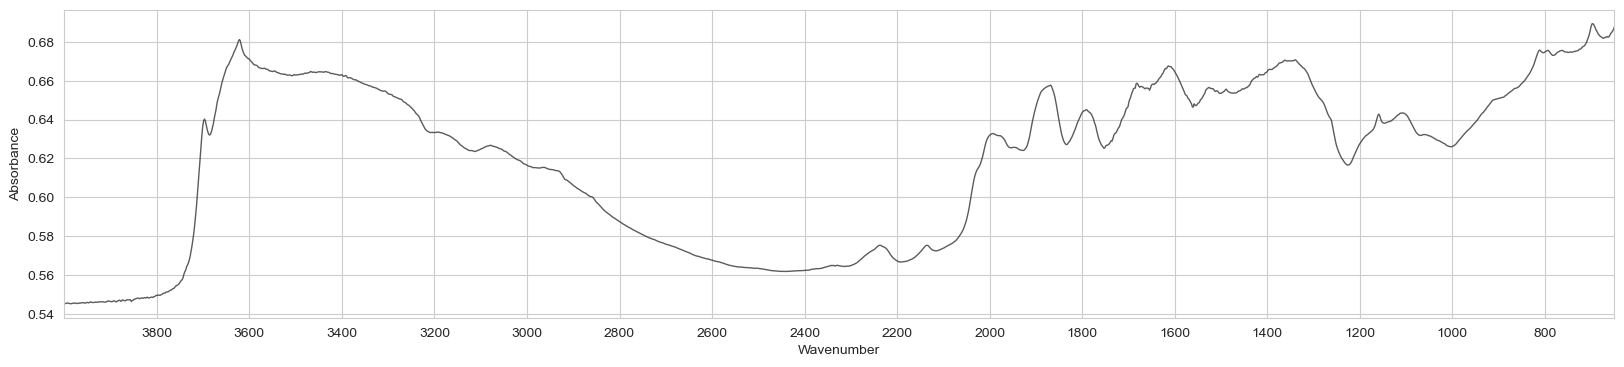

In [543]:
plot_spectra(sample_signal, wavenumbers, ascending=False)

In [416]:
kaolinite = [1e7 / i for i in [1395, 1415, 2165, 2207]]; print('kaolinite: ', kaolinite)
illite = [1e7 / i for i in [2207, 2345, 2450]]; print('illite: ', illite)
smectite = [1e7 / i for i in [1912, 2207, 2230]]; print('smectite', smectite)   

kaolinite:  [7168.458781362007, 7067.137809187279, 4618.937644341801, 4531.037607612143]
illite:  [4531.037607612143, 4264.392324093817, 4081.6326530612246]
smectite [5230.125523012553, 4531.037607612143, 4484.304932735426]


In [293]:
cA, cD = pywt.dwt(sample_signal, 'db2')

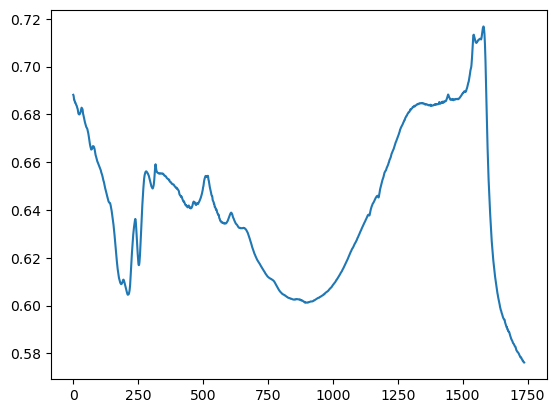

In [296]:
plt.plot(range(len(sample_signal)), sample_signal)

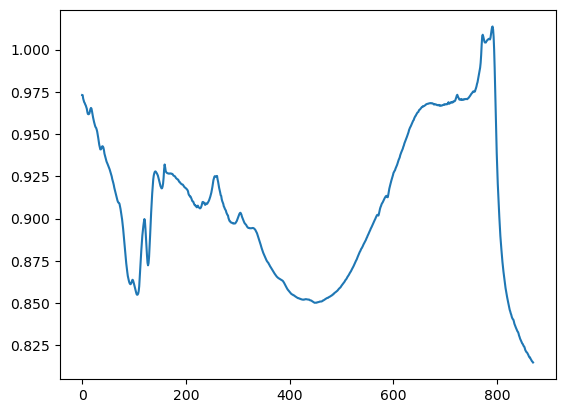

In [294]:
plt.plot(range(len(cA)), cA)

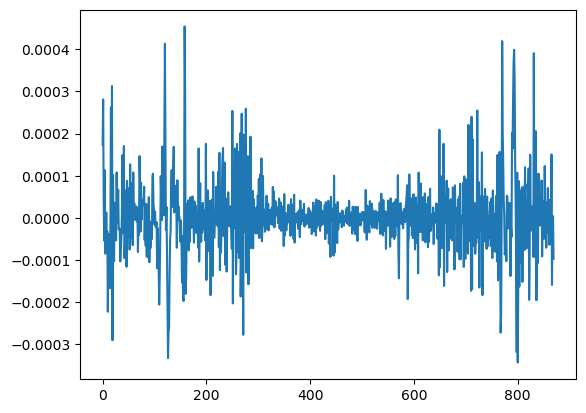

In [295]:
plt.plot(range(len(cD)), cD)

In [343]:
pywt.Wavelet('db3').dec_len

6

In [345]:
2**7

128

In [342]:
n_coeffs_selected = len([element for level in coeffs for element in level if element > 0.01])
print(n_coeffs_selected)
100 * n_coeffs_selected / X.shape[-1]


47


4.952581664910432

In [315]:
# for coeff in coeffs: print(coeff)

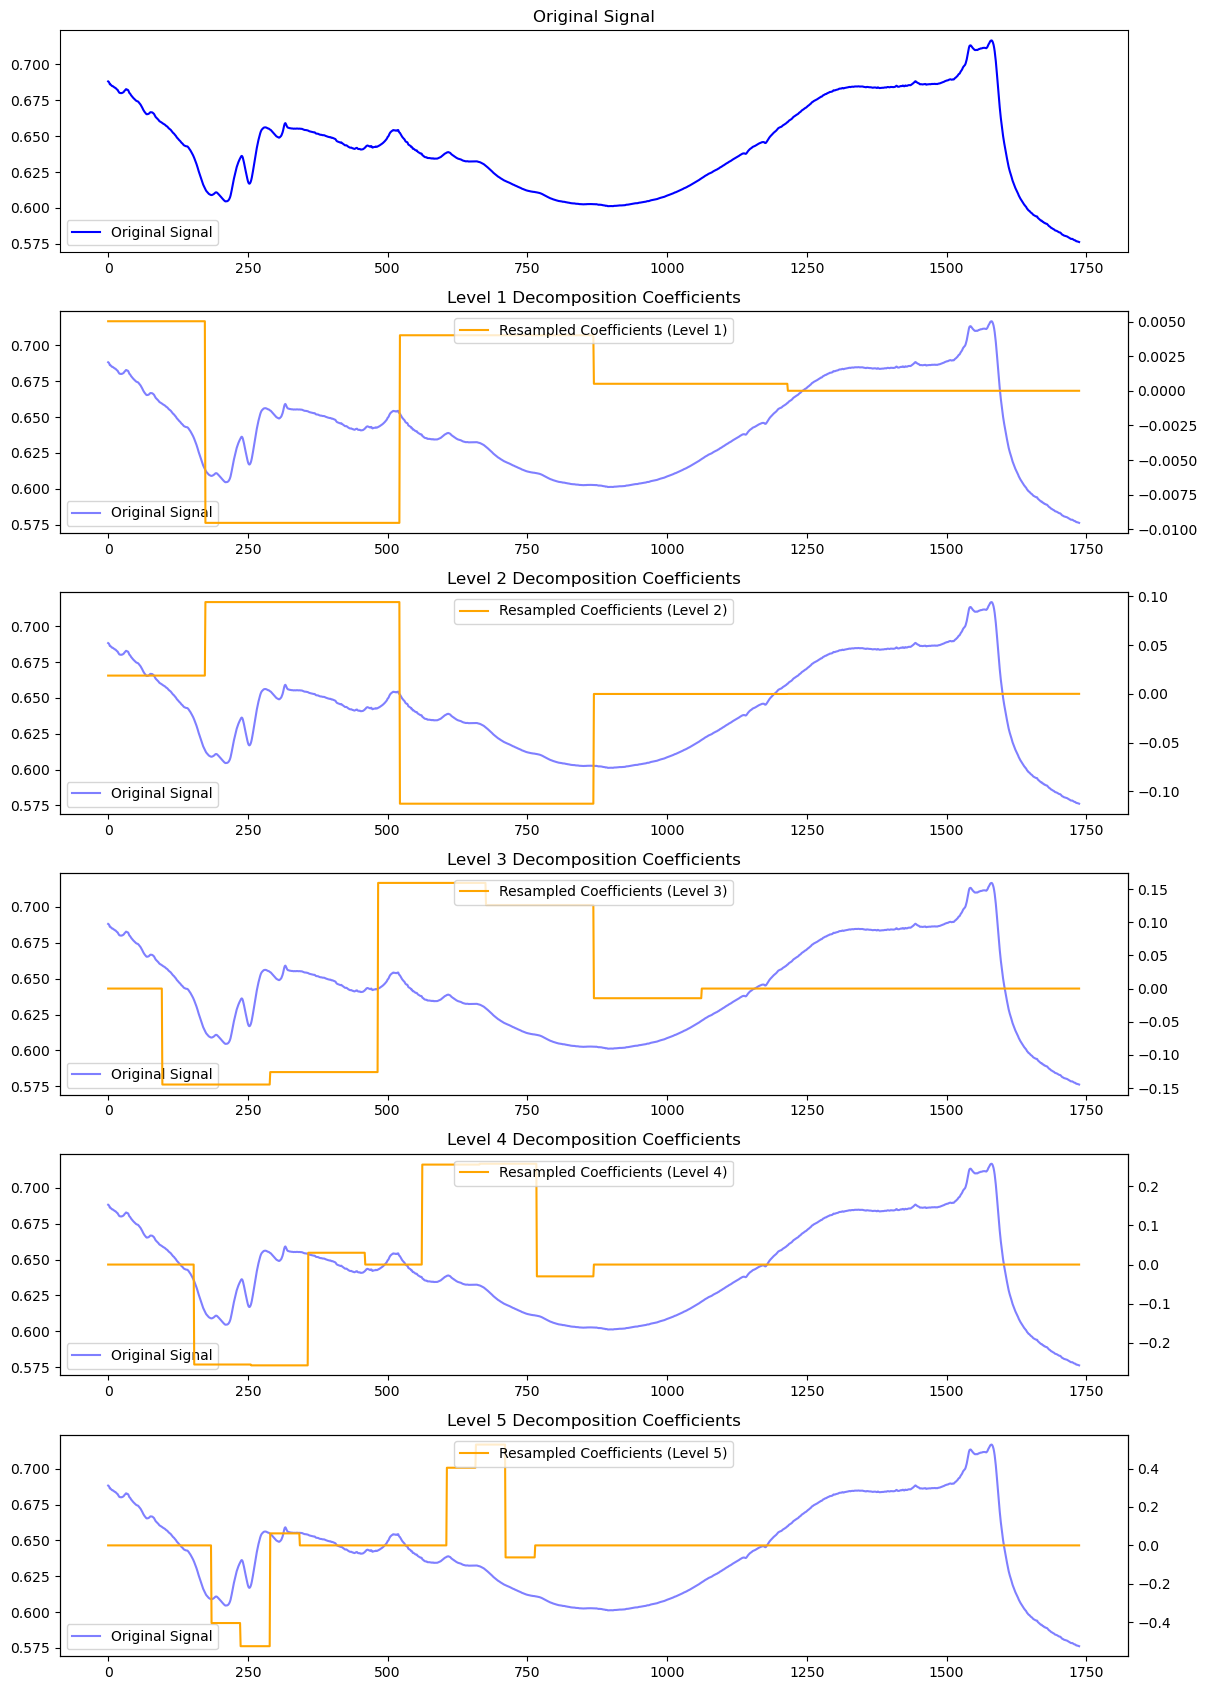

In [313]:
# Creating a new figure for plotting with separate y-axis scales for the original signal and coefficients
plt.figure(figsize=(12, max_level * 3 + 2))

# Plot the original signal
plt.subplot(max_level + 1, 1, 1)
plt.plot(sample_signal, label='Original Signal', color='blue')
plt.title('Original Signal')
plt.legend(loc='lower left')

# Iterate through each level of decomposition
for level in range(max_level):
    # Extracting the coefficients
    cA = coeffs[level]

    # Interpolate the coefficients to the length of the original signal
    x_scale = np.linspace(0, signal_length - 1, len(cA))
    interp_cA = interp1d(x_scale, cA, kind='nearest', fill_value='extrapolate')
    cA_resampled = interp_cA(np.arange(signal_length))

    # Plotting the original signal and resampled coefficients on separate y-axes
    ax1 = plt.subplot(max_level + 1, 1, level + 2)
    ax2 = ax1.twinx()

    ax1.plot(sample_signal, label='Original Signal', color='blue', alpha=0.5)
    ax2.plot(cA_resampled, label=f'Resampled Coefficients (Level {level + 1})', color='orange')

    ax1.set_title(f'Level {level + 1} Decomposition Coefficients')
    ax1.legend(loc='lower left')
    ax2.legend(loc='upper center')

plt.tight_layout()
plt.show()


In [17]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Toy example

4


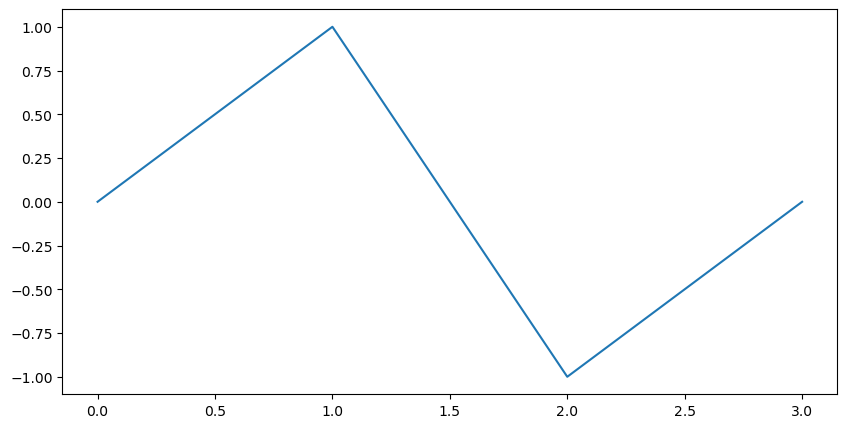

In [297]:
peak_sig = np.array([0, 1, -1, 0])
# peak_sig = np.array([0, 1, 0, -1, 0])
print(len(peak_sig))

plt.figure(figsize=(10, 5))
plt.plot(range(len(peak_sig)), peak_sig);

In [298]:
np.argmin(toy_sig)

18

length sig:  128


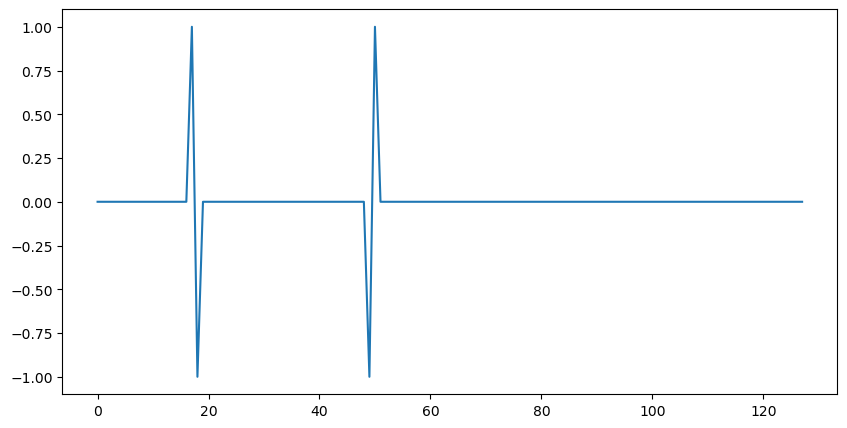

In [300]:
n, n1, n2 = 128, 16, 28

toy_sig = np.r_[np.zeros(n1), peak_sig, np.zeros(n2), -peak_sig, np.zeros(n-n1-n2-2*len(peak_sig))]
print('length sig: ', len(toy_sig))
plt.figure(figsize=(10, 5))
plt.plot(range(len(toy_sig)), toy_sig);

In [301]:
wavelet_type = 'db2'
print(pywt.Wavelet(wavelet_type))
max_level = pywt.dwt_max_level(data_len=len(toy_sig), 
                               filter_len=pywt.Wavelet(wavelet_type).dec_len)
max_level

Wavelet db2
  Family name:    Daubechies
  Short name:     db
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


5

In [302]:
?pywt.wavedec

Signature: pywt.wavedec(data, wavelet, mode='symmetric', level=None, axis=-1)
Docstring:
Multilevel 1D Discrete Wavelet Transform of data.

Parameters
----------
data: array_like
    Input data
wavelet : Wavelet object or name string
    Wavelet to use
mode : str, optional
    Signal extension mode, see :ref:`Modes <ref-modes>`.
level : int, optional
    Decomposition level (must be >= 0). If level is None (default) then it
    will be calculated using the ``dwt_max_level`` function.
axis: int, optional
    Axis over which to compute the DWT. If not given, the
    last axis is used.

Returns
-------
[cA_n, cD_n, cD_n-1, ..., cD2, cD1] : list
    Ordered list of coefficients arrays
    where ``n`` denotes the level of decomposition. The first element
    (``cA_n``) of the result is approximation coefficients array and the
    following elements (``cD_n`` - ``cD_1``) are details coefficients
    arrays.

Examples
--------
>>> from pywt import wavedec
>>> coeffs = wavedec([1,2,3,4,5,6,7,8

In [304]:
#['zero', 'constant', 'symmetric', 'periodic', 'smooth', 'periodization', 'reflect', 'antisymmetric', 'antireflect']
coeffs = pywt.wavedec(toy_sig, wavelet_type, mode='zero')

In [305]:
for i, level in enumerate(coeffs):
    print(f'level: {i} | # coeffs: {len(level)} | max: {np.max(level):.3f} | argmax: {np.argmax(level)} | argmin: {np.argmin(level)}')     

level: 0 | # coeffs: 6 | max: 0.005 | argmax: 0 | argmin: 1
level: 1 | # coeffs: 6 | max: 0.094 | argmax: 1 | argmin: 2
level: 2 | # coeffs: 10 | max: 0.159 | argmax: 3 | argmin: 1
level: 3 | # coeffs: 18 | max: 0.258 | argmax: 7 | argmin: 3
level: 4 | # coeffs: 34 | max: 0.525 | argmax: 13 | argmin: 5
level: 5 | # coeffs: 65 | max: 1.061 | argmax: 25 | argmin: 9


In [284]:
cA, cD = pywt.dwt(toy_sig, 'db2', mode='symmetric')

In [287]:
cA

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.12940952,  0.61237244,
       -0.48296291,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.12940952,
       -0.61237244,  0.48296291,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

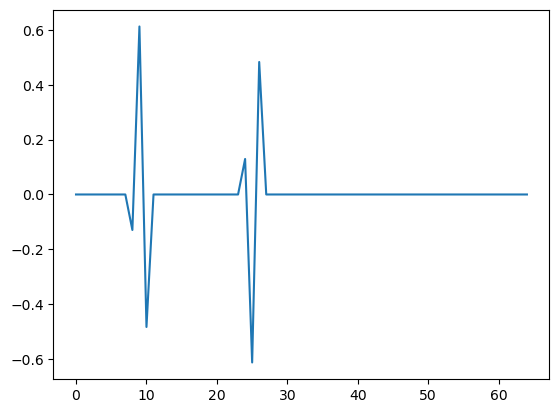

In [290]:
plt.plot(range(len(cA)), cA)

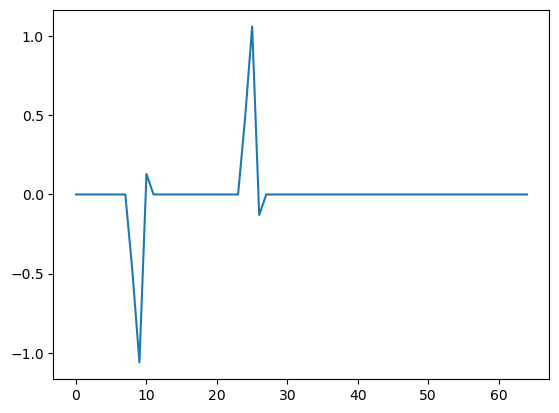

In [292]:
plt.plot(range(len(cD)), cD)

In [281]:
cD

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.48296291, -1.06066017,
        0.12940952,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.48296291,
        1.06066017, -0.12940952,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [248]:
2**9

512

In [239]:
import pywt

# Choose a wavelet
wavelet_name = 'db2'  # For example, Daubechies 2
wavelet = pywt.Wavelet(wavelet_name)

# Get the lengths of the decomposition and reconstruction filters
dec_len = wavelet.dec_len
rec_len = wavelet.rec_len

# Print the filter lengths
print(f"Decomposition filter length of {wavelet_name}: {dec_len}")
print(f"Reconstruction filter length of {wavelet_name}: {rec_len}")

# The support length of the wavelet can be considered as the maximum of these two lengths
support_length = max(dec_len, rec_len)
print(f"Support length of {wavelet_name} wavelet: {support_length}")


Decomposition filter length of db2: 4
Reconstruction filter length of db2: 4
Support length of db2 wavelet: 4


In [231]:
128 // 4

32

In [ ]:
128, 64, 32, 16, 8, 4, 2

In [219]:
N = 2

2**N - 1

3

In [214]:
level = 6

wavelet = pywt.Wavelet(wavelet_name)
_, _, support = wavelet.wavefun(level=1)

128 // 2**(level-1)

4

In [216]:
128//31

4

In [215]:
len(support)

31

In [171]:
#2**6
8

64

In [167]:
# 0 0 0 0 0 ... 0 1 0 -1 ... 0 0 0 0 0 ...

In [168]:
# 0, 4, 8, 12, 16
coeffs[6]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [169]:
coeffs[7]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.41421356,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -1.41421356,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
# db1 has four points

In [55]:
128 / 32

4.0

In [71]:
print(psi)
print(x)
x

[ 0.  1. -1.  0.]
[0.  0.5 1.  1.5]


array([0. , 0.5, 1. , 1.5])

In [74]:
?pywt.Wavelet

Init signature: pywt.Wavelet(self, /, *args, **kwargs)
Docstring:     
Wavelet(name, filter_bank=None) object describe properties of
a wavelet identified by name.

In order to use a built-in wavelet the parameter name must be
a valid name from the wavelist() list.
To create a custom wavelet object, filter_bank parameter must
be specified. It can be either a list of four filters or an object
that a `filter_bank` attribute which returns a list of four
filters - just like the Wavelet instance itself.
File:           ~/mambaforge/envs/lssm/lib/python3.11/site-packages/pywt/_extensions/_pywt.cpython-311-darwin.so
Type:           type
Subclasses:     

In [110]:
# pywt.wavelist()

In [84]:
x

array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
       0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
       0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
       0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.07421875,
       0.078125  , 0.08203125, 0.0859375 , 0.08984375, 0.09375   ,
       0.09765625, 0.1015625 , 0.10546875, 0.109375  , 0.11328125,
       0.1171875 , 0.12109375, 0.125     , 0.12890625, 0.1328125 ,
       0.13671875, 0.140625  , 0.14453125, 0.1484375 , 0.15234375,
       0.15625   , 0.16015625, 0.1640625 , 0.16796875, 0.171875  ,
       0.17578125, 0.1796875 , 0.18359375, 0.1875    , 0.19140625,
       0.1953125 , 0.19921875, 0.203125  , 0.20703125, 0.2109375 ,
       0.21484375, 0.21875   , 0.22265625, 0.2265625 , 0.23046875,
       0.234375  , 0.23828125, 0.2421875 , 0.24609375, 0.25      ,
       0.25390625, 0.2578125 , 0.26171875, 0.265625  , 0.26953125,
       0.2734375 , 0.27734375, 0.28125   , 0.28515625, 0.28906

In [114]:
len(x)

258

In [118]:
psi

array([ 0.,  1., -1.,  0.])

In [119]:
x

array([0. , 0.5, 1. , 1.5])

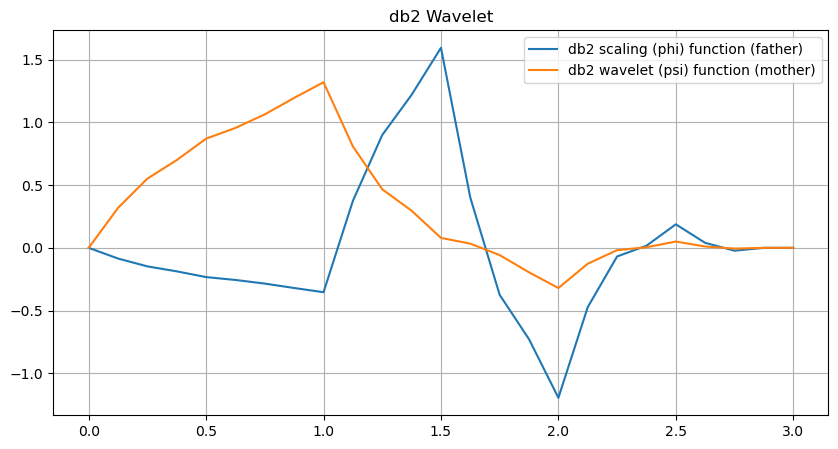

In [312]:
import matplotlib.pyplot as plt

wavelet_name = 'db2'
# Create the Daubechies 1 wavelet (db1)
wavelet = pywt.Wavelet(wavelet_name)

# Get the wavelet function values on the built-in support interval
#level=1
# phi: father (scaling fun), and psi: mother (wavelet fun)
phi, psi, x = wavelet.wavefun(level=3)

# Plot the wavelet function
plt.figure(figsize=(10, 5))
plt.plot(x, psi, label=f'{wavelet_name} scaling (phi) function (father)')
plt.plot(x, phi, label=f'{wavelet_name} wavelet (psi) function (mother)')
plt.title(f'{wavelet_name} Wavelet')

plt.legend()
plt.grid(True)
plt.show()


In [249]:
# asymmetric least squares smoothing
# import numpy as np
# from scipy.sparse import diags
# from scipy.sparse.linalg import spsolve

# def baseline_als(y, lam, p, niter=10):
#     L = len(y)
#     D = diags([1,-2,1], [0,-1,-2], shape=(L,L-2))
#     w = np.ones(L)
#     for i in range(niter):
#         W = diags([w], [0], shape=(L,L))
#         Z = W + lam * D.dot(D.transpose())
#         z = spsolve(Z, w*y)
#         w = p * (y > z) + (1-p) * (y < z)
#     return z

# # Parameters for baseline fitting
# lam = 1e5  # Smoothness parameter
# p = 0.01   # Asymmetry parameter

# # Assuming 'spectrum' is your 1D numpy array containing the spectral data
# baseline = baseline_als(spectrum, lam, p)

# # Subtract the baseline from the original spectrum
# corrected_spectrum = spectrum - baseline

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(spectrum, label='Original Spectrum')
# plt.plot(corrected_spectrum, label='Corrected Spectrum', color='red')
# plt.plot(baseline, label='Estimated Baseline', linestyle='--')
# plt.legend()
# plt.show()
